### MLP-pitmodel

test the new feature 'cur_cautionlaps'

base: MLP-pitmodel-plen2

build a pitstop dataset with <cautions_laps, pitage, gap2nextpit>
gluonts interface of Dataset = Iterable[DataEntry], DataEntry = Dict(str, any)

+ input pitstop dataset, remove pitstops with pit_oncaution = 1, refer to lapstatus_dataset-fastrun
+ context_length = 1, prediction_length = 1
+ target : gap to nextpit
+ covariates are: cautions_laps, pitage, (carid, eid)
+ modeling the distribution of nextpit-gap


In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import random
import mxnet as mx
from mxnet import gluon
import pickle
import json
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import inspect
from scipy import stats
from pathlib import Path 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from gluonts.dataset.util import to_pandas
from pathlib import Path
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.model.predictor import Predictor
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.distribution.student_t import StudentTOutput
from gluonts.model.forecast import SampleForecast

from indycar.model.mlp import MLPEstimator

INFO:root:Using GPU


In [2]:
import os
os.getcwd()

'/scratch_hdd/hpda/indycar/notebook/22.PaperFinal'

In [56]:

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def test_flag(a, bitflag):
    return (a & bitflag) ==  bitflag

#
# remove NaN at the tail
# there should be no nans in the middle of the ts
COL_LAPTIME=0
COL_RANK=1
COL_TRACKSTATUS=2
COL_LAPSTATUS=3
COL_TIMEDIFF=4
COL_CAUTION_LAPS_INSTINT=5
COL_LAPS_INSTINT= 6
COL_ELAPSED_TIME= 7
COL_LAP2NEXTPIT = 8


MODE_ORACLE = 0
MODE_NOLAP = 1
MODE_NOTRACK = 2
MODE_TESTZERO = 4
MODE_TESTCURTRACK = 8
#MODE_STR={MODE_ORACLE:'oracle', MODE_NOLAP:'nolap',MODE_NOTRACK:'notrack',MODE_TEST:'test'}

def split_ts(rec, carno, eid, include_end = False):
    """
    input: 
        ts
    output:
        nextpit records
    """
    output = []
    pitstops = np.where(rec[COL_LAPSTATUS,:] == 1)[0]
    
    if len(pitstops)==0:
        print('no pit ts')
        return output
    
    #pit_oncaution = np.zeros_like((pitstops))
    #for pit in pitstops:
    #    if rec[COL_TRACKSTATUS,:] == 1:
    #        pit_oncaution = 1
    pit_oncaution = np.zeros_like((rec[COL_LAP2NEXTPIT,:]))
    stint_len = np.zeros_like((rec[COL_LAP2NEXTPIT,:]))
    pos = 0
    for pit in pitstops:
        if rec[COL_TRACKSTATUS,pit] == 1:
            #next pit is oncaution
            # set pos -> pit as oncaution
            pit_oncaution[pos:pit] = 1
        else:
            pit_oncaution[pos:pit] = 0
            
        stint_len[pos:pit] = pit - pos
        pos = pit
        
        
    # calc cur_cautionlaps
    # accumulate consecutive caution laps
    trackstatus = rec[COL_TRACKSTATUS,:]
    lapstatus = rec[COL_LAPSTATUS,:]
    
    #import pdb; pdb.set_trace()
    
    cur_cautionlaps = np.zeros_like(trackstatus)
    cautionlaps_acc = 0
    for idx in range(len(trackstatus)):
        if (trackstatus[idx] == 0) or (lapstatus[idx] == 1):
            #reset
            cautionlaps_acc = 0
        else:
            cautionlaps_acc += 1
            
        #save state
        cur_cautionlaps[idx] = cautionlaps_acc
        
            
    #prepare output : lap2nextpit, CAUTION_LAPS_INSTINT,LAPS_INSTINT, pit_oncaution, carno, eid, lap, stintlen
    if include_end:
        #rec = rec[:, ~np.isnan(rec[run_ts,:])]
        totallen = len(rec[COL_RANK, ~np.isnan(rec[COL_RANK,:])])
    else:
        totallen = pitstops[-1]
        
    # set the last stint target = 999, an invalid lap2nextpit
    for idx in range(totallen):
        output.append([ rec[COL_LAP2NEXTPIT ,idx] if idx < pitstops[-1] else 999
                        ,rec[COL_CAUTION_LAPS_INSTINT ,idx]
                        ,rec[COL_LAPS_INSTINT ,idx]
                        ,pit_oncaution[idx]
                        ,carno
                        ,eid
                        ,idx
                        ,stint_len[idx]
                        ,cur_cautionlaps[idx]
                      ])
        
    return output

def make_dataset_byevent(test_event = 'Indy500-2018', include_end = False):
    """
    split the ts to train and test part by the ratio
    
    oracle_mode: false to simulate prediction in real by 
        set the covariates of track and lap status as nan in the testset
            
    
    """    
    useeid = False
    run_ts = COL_LAP2NEXTPIT
    train_set = []
    test_set = []
    
    #_data: eventid, carids, datalist[carnumbers, features, lapnumber]->[laptime, rank, track, lap]]
    for _data in laptime_data:
        _train = []
        _test = []
        
        if events[_data[0]] == test_event:
            test_mode = True
        else:
            test_mode = False
            
        # process for each ts
        for rowid in range(_data[2].shape[0]):
            # rec[features, lapnumber] -> [laptime, rank, track_status, lap_status,timediff]]
            rec = _data[2][rowid].copy()
            
            #remove nan(only tails)
            nans, x= nan_helper(rec[run_ts,:])
            nan_count = np.sum(nans)             
            rec = rec[:, ~np.isnan(rec[run_ts,:])]
            
            # remove short ts
            totallen = rec.shape[1]
            
            carno = _data[1][rowid]
            carid = global_carids[_data[1][rowid]]
            
            eid = _data[0]
            
            # all go to train set
            output = split_ts(rec, carno, eid, include_end= include_end)
            #if len(output) == 0:
            #    continue
            
            test_rec_cnt = 0
            if not test_mode:
                _train.extend(output)
                
            else:
                _test.extend(output)
                test_rec_cnt += 1
            
            #add one ts
            print(f'carno:{carno}, totallen:{totallen}, nancount:{nan_count}, test_reccnt:{test_rec_cnt}')

        train_set.extend(_train)
        test_set.extend(_test)

    print(f'train len:{len(train_set)}, test len:{len(test_set)}')
    
    return train_set, test_set

def save_dataset(datafile,freq, prediction_length, cardinality, train_ds, test_ds):
    with open(datafile, 'wb') as f:
        #pack [global_carids, laptime_data]
        savedata = [freq, prediction_length, cardinality, train_ds, test_ds]
        #savedata = [freq, train_set, test_set]
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

### create dbs

In [57]:
_inlap_status = 0
#years = ['2013','2014','2015','2016','2017','2018','2019']
years = ['2013','2014','2015','2016','2017','2018','2019']
#events = ['Indy500']
events = [f'Indy500-{x}' for x in years]
events_id={key:idx for idx, key in enumerate(events)}
dbid = f'Indy500_{years[0]}_{years[-1]}_v9_p{_inlap_status}'
testevent = 'Indy500-2018'
# start from here
import pickle
#with open('laptime_rank_timediff_fulltest-oracle-%s.pickle'%year, 'rb') as f:
with open(f'laptime_rank_timediff_pit-oracle-{dbid}.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    global_carids, laptime_data = pickle.load(f, encoding='latin1') 

In [58]:
include_end = True
includeend_str = '-includeend' if include_end else ''

In [59]:
#
# include end
#
train, test =  make_dataset_byevent(test_event = 'Indy500-2018', include_end = include_end)
#prepare output : lap2nextpit, CAUTION_LAPS_INSTINT,LAPS_INSTINT, pit_oncaution, carno, eid, lap
df_train = pd.DataFrame(train,columns=['lap2nextpit', 'caution_laps','pitage', 'pit_oncaution', 
                 'carno','eid','lap','stint_len','cur_cautionlaps'])
df_test = pd.DataFrame(test,columns=['lap2nextpit', 'caution_laps','pitage', 'pit_oncaution', 
                 'carno','eid','lap','stint_len','cur_cautionlaps'])

datafile = f'pitstop_nextpit_dataset-{dbid}-t{testevent}-withcurcautionlaps{includeend_str}.pickle'
with open(datafile, 'wb') as f:
    savedata = [df_train, df_test, events, testevent]
    pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

carno:1, totallen:200, nancount:0, test_reccnt:0
carno:2, totallen:200, nancount:0, test_reccnt:0
carno:3, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:4, totallen:0, nancount:200, test_reccnt:0
carno:5, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:6, totallen:30, nancount:170, test_reccnt:0
carno:7, totallen:177, nancount:23, test_reccnt:0
carno:8, totallen:200, nancount:0, test_reccnt:0
carno:9, totallen:200, nancount:0, test_reccnt:0
carno:10, totallen:187, nancount:13, test_reccnt:0
carno:11, totallen:200, nancount:0, test_reccnt:0
carno:12, totallen:200, nancount:0, test_reccnt:0
carno:14, totallen:200, nancount:0, test_reccnt:0
carno:15, totallen:170, nancount:30, test_reccnt:0
carno:16, totallen:179, nancount:21, test_reccnt:0
carno:18, totallen:200, nancount:0, test_reccnt:0
carno:19, totallen:200, nancount:0, test_reccnt:0
carno:20, totallen:200, nancount:0, test_reccnt:0
carno:21, totallen:170, nancount:30, test_reccnt:0
carno:22, totallen:200, nancount:

In [60]:
datafile = f'pitstop_nextpit_dataset-{dbid}-t{testevent}-withcurcautionlaps{includeend_str}.pickle'
with open(datafile, 'wb') as f:
    savedata = [df_train, df_test, events, testevent]
    pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

In [61]:
#include end


In [62]:
df_train

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
0,30.0,0.0,1.0,0.0,1,0,0,30.0,0.0
1,29.0,0.0,2.0,0.0,1,0,1,30.0,0.0
2,28.0,0.0,3.0,0.0,1,0,2,30.0,0.0
3,27.0,1.0,4.0,0.0,1,0,3,30.0,1.0
4,26.0,2.0,5.0,0.0,1,0,4,30.0,2.0
...,...,...,...,...,...,...,...,...,...
34024,1.0,1.0,1.0,1.0,98,6,175,2.0,1.0
34025,2.0,0.0,0.0,1.0,98,6,176,2.0,0.0
34026,1.0,1.0,1.0,1.0,98,6,177,2.0,1.0
34027,1.0,0.0,0.0,1.0,98,6,178,1.0,0.0


In [63]:
#make gluonts
from sklearn.preprocessing import StandardScaler,MinMaxScaler

def makedb(data, scaler='standard', perm = True):
    db = []
    start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series
    
    scalers = {'minmax':MinMaxScaler(), 'standard':StandardScaler()}
    
    if isinstance(scaler, str):
        if scaler in scalers:
            scaler = scalers[scaler]
            scaler.fit(data)
            df = scaler.transform(data)
        else:
            # no scaler
            df = data
    else:
        #use input scaler
        #scaler.fit(data)
        df = scaler.transform(data)
        
    
    #permute
    if perm:
        perm = np.random.permutation(len(df))
        df = df[perm]
    
    for x in df:
        
        #db.append({'target':np.array(x[0]), 'feat':[np.array(x[1]),np.array(x[2])]})
        db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2],x[3]]),
                  "start":start, 'forecast_start':start})
        #db.append({'target':np.array(x[0]).reshape((1,-1)), 'feat':[np.array(x[1]).reshape((1,-1)),np.array(x[2]).reshape((1,-1))]})
        
    return db, scaler, df


In [64]:
def make_fulltestdb(scaler, maxgap=60, maxcautionlen=20):
    db = []
    start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series

    data = []
    for caution_lap in range(maxgap):
        for pitage in range(caution_lap, maxgap):
            for cur_cautionlap in range(0, caution_lap+1):
                data.append([0.,caution_lap, pitage, cur_cautionlap])
    data = np.array(data)
    
    if not isinstance(scaler, str):
        df = scaler.transform(data)
    else:
        df = data
    
    #data
    print(f'make full testdb: {len(df)} records')
    for x in df:
        db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2],x[3]]),
                  "start":start, 'forecast_start':start})
            
    return db, scaler, df, data

In [65]:
train_sel = df_train[(df_train['pit_oncaution']==0) &(df_train['stint_len']>23)]

train_sel_2013_2017 = train_sel[train_sel['eid']<5]
train_all_2013_2017 = df_train[df_train['eid']<5]

print(len(train_all_2013_2017), len(train_sel_2013_2017))    

test_sel = df_test[(df_test['pit_oncaution']==0) &(df_test['stint_len']>23)]
test_all = df_test

train_sel_noshort = df_train[(df_train['stint_len']>15)]
train_sel_noshort_2013_2017 = train_sel_noshort[train_sel_noshort['eid']<5]
test_sel_noshort = df_test[(df_test['stint_len']>15)]


28186 13976


In [66]:
_data = {}
#model store
p, t, s, e = {}, {} ,{}, {}

# negbin, use no sclaer
#train_ds, scaler = makedb(train_sel[['lap2nextpit','caution_laps','pitage']].values, scaler='')
#train_ds, scaler = makedb(train_sel[['lap2nextpit','caution_laps','pitage']].values, scaler='minmax')
#train_ds, scaler, train_set = makedb(train_sel[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values, scaler='standard')
#test_ds, _, test_set = makedb(test_sel[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values, scaler, perm=False)

# selected db
trainset = train_sel_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
testset = test_sel[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
train_ds, scaler, _ = makedb(trainset, scaler='standard')
test_ds, _, _ = makedb(testset, scaler, perm=False)

_data['sel'] = [trainset, testset, train_ds, test_ds, scaler]


# selected db
trainset = train_all_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
testset = test_all[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
train_ds, scaler, _ = makedb(trainset, scaler='standard')
test_ds, _, _ = makedb(testset, scaler, perm=False)

_data['all'] = [trainset, testset, train_ds, test_ds, scaler]


# selected db
trainset = train_sel_noshort_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
testset = test_sel_noshort[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
train_ds, scaler, _ = makedb(trainset, scaler='standard')
test_ds, _, _ = makedb(testset, scaler, perm=False)

_data['noshort'] = [trainset, testset, train_ds, test_ds, scaler]

In [67]:
datafile = f'pitstop_nextpit_dataset-{dbid}-t{testevent}-alldata-withcurcautionlaps{includeend_str}.pickle'
with open(datafile, 'wb') as f:
    savedata = [df_train, df_test, events, testevent, _data]
    pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

### train

In [13]:
def train_model(epochs, layers=[10,10,5], output = 'student', dropout = .5, id='all'):
    distr_outputs ={'student':StudentTOutput(),  
                    'negbin':NegativeBinomialOutput() 
                   }
    if not output in distr_outputs:
        print(f'distr_output: {output} not found error.')
        return
    
    distr_output = distr_outputs[output]
    
    modelid = 'mlp-d%s-e%s-l%s-%s-d%s'%(id, epochs, '-'.join([str(x) for x in layers]), output, dropout)
    
    estimator = MLPEstimator(
        num_hidden_dimensions=layers,
        prediction_length=1,
        context_length=1,
        freq='1min',
        dropout = dropout,
        distr_output = distr_output,
        trainer=Trainer(ctx="gpu(0)", 
                        batch_size = 32,
                        epochs= epochs,
                        learning_rate=1e-3,
                        hybridize=False,
                        num_batches_per_epoch=100
                       )
    )    

    predictor = estimator.train(train_ds)

    return predictor, modelid

In [14]:
def eval_model(predictor, test_ds):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset    
        predictor=predictor,  # predictor                                  
        num_samples=1000,  # number of sample paths we want for evaluation 
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)     
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9]) 
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    print(json.dumps(agg_metrics, indent=4)) 
    return tss, forecasts, agg_metrics


def raw_eval(tss, forecasts):
    """
    scaler
    """
    rec = np.zeros((4))

    truth, pred = [],[]
    #go through the dataset
    for idx in range(len(tss)):
        rec[0] = list(tss[idx].values)[0]
    
        if isinstance(scaler, str):
            truth.append(int(rec[0]))
        else:
            truth.append(int(scaler.inverse_transform(rec)[0]))
    
        rec[0] = np.mean(forecasts[idx].samples)
        
        if isinstance(scaler, str):
            pred.append(int(rec[0]))    
        else:
            pred.append(int(scaler.inverse_transform(rec)[0]))        

    #get mae
    mae = mean_absolute_error(truth, pred)
    print('mae = ', mae)
    return mae
    

def save_model(predictor, outdir):
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    predictor.serialize(Path(outdir)) 

def get_pred(tss, forecasts, idx,raw_forecast = False):
    rec = np.zeros((4))
    rec[0] = list(tss[idx].values)[0]
    
    if isinstance(scaler, str):
        truth = int(rec[0])
    else:
        truth = int(scaler.inverse_transform(rec)[0])
    
    ret = []
    for sample in forecasts[idx].samples:
        rec[0] = sample
        if isinstance(scaler, str) or raw_forecast:
            ret.append(int(rec[0]))    
        else:
            ret.append(int(scaler.inverse_transform(rec)[0]))    
        
    print('idx:', idx, 't:', truth, 'p:', int(np.mean(ret)))
    plt.hist(ret, bins=range(min(ret),max(ret)+1), alpha=0.7, label='%s'%idx)
    return truth, ret

def run_test(tss, forecasts, testlist, raw_forecast = False):
    for idx in testlist:
        get_pred(tss, forecasts, idx, raw_forecast)
    plt.legend()

In [15]:
### pitmodel
class PitModel():
    """
     <caution_lap, pitage> -> [distribution]    
     distribution := sorted cdf [val:probability, val2:p2, ...]
         [0,:] -> val
         [1,:] -> cdf p
         
     no scaler, raw feat and target
    
    """
    def __init__(self, modelfile=''):
        self.model = {}
        self.name = ''
        
        if modelfile:
            self.load_model(modelfile)
                
    def load_model(self, modelfile):
        with open(modelfile, 'rb') as f:
            self.name, self.model = pickle.load(f, encoding='latin1')
            print(f'init model:{self.name}')
        
    def save_model(self, modelname, test_ds, forecasts, scaler):
        
        model = {}
        
        #get the sclaer for the first column(lap2nextpit)
        sc, scf = '', ''
        if isinstance(scaler, StandardScaler):
            sc = StandardScaler()
            sc.scale_ = scaler.scale_[0]
            sc.mean_ = scaler.mean_[0]
            sc.var_ = scaler.var_[0]

            scf = StandardScaler()
            scf.scale_ = scaler.scale_[1:]
            scf.mean_ = scaler.mean_[1:]
            scf.var_ = scaler.var_[1:]

        
        for idx, rec in enumerate(test_ds):
            feat = rec[1:]
                
            key = '-'.join([str(int(x)) for x in feat])
            
            if not key in model:
            
                samples = forecasts[idx].samples.reshape(-1)
                
                if not isinstance(sc, str):
                    samples = sc.inverse_transform(samples)
                
                #force to prediction to be valid lap2nextpit
                samples = samples.astype(int)
                samples = samples[samples > 0]

                #
                valset = set(list(samples))
                plen = len(valset)
                distr = np.zeros((2, plen))
                distr[0, :] = sorted(valset)
                smap = {val:id for id, val in enumerate(distr[0, :])}
                for s in samples:
                    distr[1,smap[s]] += 1
                tsum = np.sum(distr[1,:])
                distr[1, :] /= tsum
                distr[1, :] = np.cumsum(distr[1, :])

                model[key] = distr
                
        #save model
        self.model = model
        self.name = modelname
        with open(modelname, 'wb') as f:
            savedata = [self.name, self.model]
            pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)        
        print(f'save model {modelname} with {len(self.model)} keys.')
                
    def predict(self, *args):
        key = '-'.join([str(int(x)) for x in args])
        #if key in self.model:
        try:
            distr = self.model[key]
            
            #[0, 1.)
            p = np.random.random()  
            i = np.sum(distr[1,:] < p)
            
            return distr[0,i]
        except:
            #exception
            #todo, backto special model
            print(f'ERROR: key {key} not found in model')
                       
    def forecast_ds(self, test_ds, forecasts):
        """
        test_ds as testset, the unsclaed input
        forecasts ; the template
        """
        
        plen = len(test_ds)
        sample_cnt = forecasts[0].samples.shape[0]
        assert(plen == len(forecasts))
        

        #build a new forecasts object
        nf = []
        for fc in forecasts:
            nfc = SampleForecast(samples = np.zeros_like(fc.samples), 
                                 freq=fc.freq, start_date=fc.start_date)
            nf.append(nfc)
        
        for idx, rec in enumerate(test_ds):
            feat = rec[1:]
                    
            onecast = np.zeros((sample_cnt))
            for i in range(sample_cnt):
                onecast[i] = self.predict(feat[0], feat[1],feat[2])
        
            nf[idx].samples = onecast

        return nf
    

def save_full_pitmodel(mid, runid, maxgap=60):
    """
    input:
        p[mid]; predictor
        runid ; 'all' or 'sel' of the trainning set
    """
    
    #get scaler
    scaler = _data[runid][4]

    # make full test set
    test_ds, _, _, test_all = make_fulltestdb(scaler, maxgap = maxgap)

    tss,forecasts, _ = eval_model(p[mid], test_ds)

    pitmodel = PitModel()

    #pitmodel.save_model(f'pitmodel-m{maxgap}-{mid}.pickle', test_all, forecasts, scaler)
    pitmodel.save_model(f'pitmodel-m{maxgap}-{mid}-1k-withcurcautionlaps.pickle', test_all, forecasts, scaler)

    return pitmodel

### best model output

In [16]:
#trainset, testset, train_ds, test_ds, scaler = _data['all']
trainset, testset, train_ds, test_ds, scaler = _data['sel']

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 171.70it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[0] Elapsed time 0.584 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.092028
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 175.58it/s, avg_epoch_loss=0.555]
INFO:root:Epoch[1] Elapsed time 0.571 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.554531
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 178.51it/s, avg_epoch_loss=0.421]
INFO:root:Epoch[2] Elapsed time 0.561 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.420910
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 180.51it/s, avg_epoch_loss=0.357]
INFO:root:Epoch[3] Elapsed time 0.555 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.357378
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 177.56it/

100%|██████████| 100/100 [00:00<00:00, 175.52it/s, avg_epoch_loss=0.0598]
INFO:root:Epoch[36] Elapsed time 0.571 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=0.059827
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 189.56it/s, avg_epoch_loss=0.049]
INFO:root:Epoch[37] Elapsed time 0.529 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.049001
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 192.16it/s, avg_epoch_loss=0.0455]
INFO:root:Epoch[38] Elapsed time 0.521 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.045496
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 192.73it/s, avg_epoch_loss=0.0399]
INFO:root:Epoch[39] Elapsed time 0.520 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.039923
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 193.49it/s, avg_epoch_loss=0.0243]
INFO:root:Epoch[40] Elapsed tim

100%|██████████| 100/100 [00:00<00:00, 175.66it/s, avg_epoch_loss=0.0189]
INFO:root:Epoch[72] Elapsed time 0.571 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.018939
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 186.18it/s, avg_epoch_loss=-.0226]
INFO:root:Epoch[73] Elapsed time 0.538 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.022608
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 175.53it/s, avg_epoch_loss=-.000706]
INFO:root:Epoch[74] Elapsed time 0.571 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-0.000706
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 186.89it/s, avg_epoch_loss=0.000716]
INFO:root:Epoch[75] Elapsed time 0.536 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.000716
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 186.63it/s, avg_epoch_loss=0.0174]
INFO:root:Epoch[76] 

100%|██████████| 100/100 [00:00<00:00, 160.22it/s, avg_epoch_loss=0.00309]
INFO:root:Epoch[107] Elapsed time 0.625 seconds
INFO:root:Epoch[107] Evaluation metric 'epoch_loss'=0.003089
INFO:root:Epoch[108] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 164.73it/s, avg_epoch_loss=-.0149]
INFO:root:Epoch[108] Elapsed time 0.608 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.014916
INFO:root:Epoch[109] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 176.93it/s, avg_epoch_loss=-.00852]
INFO:root:Epoch[109] Elapsed time 0.566 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.008525
INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 176.79it/s, avg_epoch_loss=0.0292]
INFO:root:Epoch[110] Elapsed time 0.567 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.029248
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 177.60it/s, avg_epoch_loss=0.0125]
IN

INFO:root:Epoch[143] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.71it/s, avg_epoch_loss=-.00346]
INFO:root:Epoch[143] Elapsed time 0.534 seconds
INFO:root:Epoch[143] Evaluation metric 'epoch_loss'=-0.003460
INFO:root:Epoch[144] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.66it/s, avg_epoch_loss=-.0177]
INFO:root:Epoch[144] Elapsed time 0.540 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=-0.017747
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.23it/s, avg_epoch_loss=0.00793]
INFO:root:Epoch[145] Elapsed time 0.535 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.007930
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.79it/s, avg_epoch_loss=0.00366]
INFO:root:Epoch[146] Elapsed time 0.537 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.003659
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.

INFO:root:Epoch[179] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.80it/s, avg_epoch_loss=0.00466]
INFO:root:Epoch[179] Elapsed time 0.531 seconds
INFO:root:Epoch[179] Evaluation metric 'epoch_loss'=0.004657
INFO:root:Epoch[180] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.20it/s, avg_epoch_loss=0.00061]
INFO:root:Epoch[180] Elapsed time 0.533 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=0.000610
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.57it/s, avg_epoch_loss=0.0115]
INFO:root:Epoch[181] Elapsed time 0.526 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.011496
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 193.53it/s, avg_epoch_loss=-.021]
INFO:root:Epoch[182] Elapsed time 0.518 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.020985
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.81i

INFO:root:Epoch[215] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.22it/s, avg_epoch_loss=0.00377]
INFO:root:Epoch[215] Elapsed time 0.535 seconds
INFO:root:Epoch[215] Evaluation metric 'epoch_loss'=0.003774
INFO:root:Epoch[216] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.48it/s, avg_epoch_loss=0.00925]
INFO:root:Epoch[216] Elapsed time 0.546 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=0.009248
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.01it/s, avg_epoch_loss=-.00465]
INFO:root:Epoch[217] Elapsed time 0.528 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-0.004648
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.99it/s, avg_epoch_loss=-.0203]
INFO:root:Epoch[218] Elapsed time 0.536 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-0.020259
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.

INFO:root:Epoch[251] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.03it/s, avg_epoch_loss=0.0113]
INFO:root:Epoch[251] Elapsed time 0.539 seconds
INFO:root:Epoch[251] Evaluation metric 'epoch_loss'=0.011325
INFO:root:Epoch[252] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.80it/s, avg_epoch_loss=-.00187]
INFO:root:Epoch[252] Elapsed time 0.542 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=-0.001874
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.23it/s, avg_epoch_loss=-.0172]
INFO:root:Epoch[253] Elapsed time 0.538 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-0.017232
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.54it/s, avg_epoch_loss=-.0192]
INFO:root:Epoch[254] Elapsed time 0.537 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-0.019248
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.8

INFO:root:Epoch[287] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 189.09it/s, avg_epoch_loss=-.0122]
INFO:root:Epoch[287] Elapsed time 0.530 seconds
INFO:root:Epoch[287] Evaluation metric 'epoch_loss'=-0.012249
INFO:root:Epoch[288] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.18it/s, avg_epoch_loss=-.0249]
INFO:root:Epoch[288] Elapsed time 0.533 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=-0.024924
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.68it/s, avg_epoch_loss=-.0171]
INFO:root:Epoch[289] Elapsed time 0.531 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-0.017112
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.09it/s, avg_epoch_loss=-.00668]
INFO:root:Epoch[290] Elapsed time 0.533 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-0.006676
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.

INFO:root:Epoch[323] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.06it/s, avg_epoch_loss=-.0164]
INFO:root:Epoch[323] Elapsed time 0.566 seconds
INFO:root:Epoch[323] Evaluation metric 'epoch_loss'=-0.016392
INFO:root:Epoch[324] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.52it/s, avg_epoch_loss=0.000877]
INFO:root:Epoch[324] Elapsed time 0.558 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=0.000877
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.16it/s, avg_epoch_loss=0.0116]
INFO:root:Epoch[325] Elapsed time 0.538 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.011646
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.82it/s, avg_epoch_loss=0.000976]
INFO:root:Epoch[326] Elapsed time 0.533 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.000976
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.

INFO:root:Epoch[359] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.65it/s, avg_epoch_loss=-.0132]
INFO:root:Epoch[359] Elapsed time 0.526 seconds
INFO:root:Epoch[359] Evaluation metric 'epoch_loss'=-0.013166
INFO:root:Epoch[360] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.22it/s, avg_epoch_loss=-.00932]
INFO:root:Epoch[360] Elapsed time 0.527 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=-0.009320
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.99it/s, avg_epoch_loss=-.0167]
INFO:root:Epoch[361] Elapsed time 0.530 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-0.016651
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.05it/s, avg_epoch_loss=-.0115]
INFO:root:Epoch[362] Elapsed time 0.536 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-0.011526
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.

INFO:root:Epoch[395] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.10it/s, avg_epoch_loss=0.0102]
INFO:root:Epoch[395] Elapsed time 0.553 seconds
INFO:root:Epoch[395] Evaluation metric 'epoch_loss'=0.010157
INFO:root:Epoch[396] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.58it/s, avg_epoch_loss=-.00667]
INFO:root:Epoch[396] Elapsed time 0.555 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=-0.006674
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.60it/s, avg_epoch_loss=-.0119]
INFO:root:Epoch[397] Elapsed time 0.565 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-0.011859
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.59it/s, avg_epoch_loss=-.0253]
INFO:root:Epoch[398] Elapsed time 0.558 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-0.025251
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.5

INFO:root:Epoch[431] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.10it/s, avg_epoch_loss=0.000197]
INFO:root:Epoch[431] Elapsed time 0.527 seconds
INFO:root:Epoch[431] Evaluation metric 'epoch_loss'=0.000197
INFO:root:Epoch[432] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.82it/s, avg_epoch_loss=0.0006]
INFO:root:Epoch[432] Elapsed time 0.522 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=0.000600
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.81it/s, avg_epoch_loss=-.0134]
INFO:root:Epoch[433] Elapsed time 0.523 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-0.013436
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 189.87it/s, avg_epoch_loss=0.00298]
INFO:root:Epoch[434] Elapsed time 0.528 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.002977
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 189.1

INFO:root:Epoch[467] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.11it/s, avg_epoch_loss=-.0317]
INFO:root:Epoch[467] Elapsed time 0.541 seconds
INFO:root:Epoch[467] Evaluation metric 'epoch_loss'=-0.031731
INFO:root:Epoch[468] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.75it/s, avg_epoch_loss=-.0122]
INFO:root:Epoch[468] Elapsed time 0.587 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=-0.012230
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.86it/s, avg_epoch_loss=-.000299]
INFO:root:Epoch[469] Elapsed time 0.534 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-0.000299
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.78it/s, avg_epoch_loss=-.0168]
INFO:root:Epoch[470] Elapsed time 0.525 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-0.016803
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190

{
    "MSE": 0.3730899632416759,
    "abs_error": 1677.403169107881,
    "abs_target_sum": 3779.0495181689503,
    "abs_target_mean": 1.03877117046975,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7029292348584517,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 618.3587925013942,
    "Coverage[0.1]": 0.0720175920835624,
    "QuantileLoss[0.5]": 1677.403169107881,
    "Coverage[0.5]": 0.19983507421660252,
    "QuantileLoss[0.9]": 1417.2056715749457,
    "Coverage[0.9]": 0.4793842770753161,
    "RMSE": 0.6108109062890708,
    "NRMSE": 0.5880129557435173,
    "ND": 0.44386906311844976,
    "wQuantileLoss[0.1]": 0.16362812647160163,
    "wQuantileLoss[0.5]": 0.44386906311844976,
    "wQuantileLoss[0.9]": 0.37501643330189,
    "mean_wQuantileLoss": 0.32750454096398046,
    "MAE_Coverage": 0.24958768554150632
}
mae =  4.5214403518416715
idx: 31 t: 31 p: 28
idx: 816 t: 44 p: 28
idx: 846 t: 14 p: 8
idx: 856 t: 4 p: 2


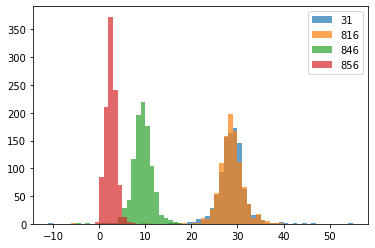

In [17]:
pm, mid = train_model(500,dropout = 0.1,id='sel')
t[mid],s[mid], e[mid] = eval_model(pm, test_ds)
p[mid] = pm

mae = raw_eval(t[mid],s[mid])

run_test(t[mid], s[mid], [31,816,846,856])

idx: 31 t: 31 p: 29
idx: 816 t: 44 p: 29
idx: 846 t: 14 p: 9
idx: 856 t: 4 p: 2


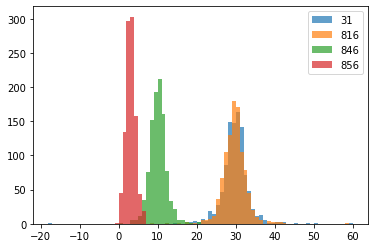

In [21]:
run_test(t[mid], s[mid], [31,816,846,856])

idx: 31 t: 31 p: 28
idx: 816 t: 44 p: 28
idx: 846 t: 14 p: 8
idx: 856 t: 4 p: 1


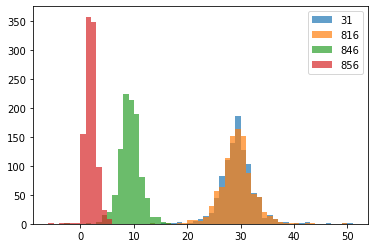

In [31]:
run_test(t[mid], s[mid], [31,816,846,856])

In [18]:
pitmodel = save_full_pitmodel(mid, 'sel', maxgap=65)

make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:45<00:00, 212.76it/s]


{
    "MSE": 2.170506532513962,
    "abs_error": 65189.56205482768,
    "abs_target_sum": 84410.26006088193,
    "abs_target_mean": 1.7620344444396605,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.307561021850031,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 42642.29159956571,
    "Coverage[0.1]": 0.7902515395052708,
    "QuantileLoss[0.5]": 65189.56205482768,
    "Coverage[0.5]": 0.9017847823817973,
    "QuantileLoss[0.9]": 24779.233726898732,
    "Coverage[0.9]": 0.9175242667779981,
    "RMSE": 1.4732639045717375,
    "NRMSE": 0.8361152696082771,
    "ND": 0.7722942922792668,
    "wQuantileLoss[0.1]": 0.5051790098598137,
    "wQuantileLoss[0.5]": 0.7722942922792668,
    "wQuantileLoss[0.9]": 0.2935571304842137,
    "mean_wQuantileLoss": 0.5236768108744314,
    "MAE_Coverage": 0.36985352955502204
}
save model pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 47905 keys.


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 167.80it/s, avg_epoch_loss=1.46]
INFO:root:Epoch[0] Elapsed time 0.598 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.459769
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 175.31it/s, avg_epoch_loss=1.16]
INFO:root:Epoch[1] Elapsed time 0.572 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1.156980
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 177.78it/s, avg_epoch_loss=1.04]
INFO:root:Epoch[2] Elapsed time 0.564 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=1.044083
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 161.45it/s, avg_epoch_loss=0.999]
INFO:root:Epoch[3] Elapsed time 0.621 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.998903
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 174.63it/s,

100%|██████████| 100/100 [00:00<00:00, 182.49it/s, avg_epoch_loss=0.829]
INFO:root:Epoch[36] Elapsed time 0.549 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=0.829319
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 179.50it/s, avg_epoch_loss=0.873]
INFO:root:Epoch[37] Elapsed time 0.558 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.873202
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 181.24it/s, avg_epoch_loss=0.882]
INFO:root:Epoch[38] Elapsed time 0.553 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.882146
INFO:root:Loading parameters from best epoch (28)
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 181.79it/s, avg_epoch_loss=0.885]
INFO:root:Epoch[39] Elapsed time 0.551 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.884538
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 165.71it/s, avg_e

INFO:root:Epoch[72] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 166.29it/s, avg_epoch_loss=0.886]
INFO:root:Epoch[72] Elapsed time 0.603 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.886178
INFO:root:Epoch[73] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 176.96it/s, avg_epoch_loss=0.859]
INFO:root:Epoch[73] Elapsed time 0.567 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.858979
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 180.35it/s, avg_epoch_loss=0.842]
INFO:root:Epoch[74] Elapsed time 0.556 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.841856
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 179.64it/s, avg_epoch_loss=0.848]
INFO:root:Epoch[75] Elapsed time 0.558 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.848252
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 160.43it/s,

100%|██████████| 100/100 [00:00<00:00, 182.78it/s, avg_epoch_loss=0.89]
INFO:root:Epoch[108] Elapsed time 0.548 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=0.890202
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.66it/s, avg_epoch_loss=0.867]
INFO:root:Epoch[109] Elapsed time 0.543 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.867041
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.07it/s, avg_epoch_loss=0.885]
INFO:root:Epoch[110] Elapsed time 0.548 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.884679
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.87it/s, avg_epoch_loss=0.881]
INFO:root:Epoch[111] Elapsed time 0.557 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.881005
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.42it/s, avg_epoch_loss=0.861]
INFO:root:Epoch[112] Ela

100%|██████████| 100/100 [00:00<00:00, 182.21it/s, avg_epoch_loss=0.846]
INFO:root:Epoch[144] Elapsed time 0.550 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=0.846030
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.43it/s, avg_epoch_loss=0.829]
INFO:root:Epoch[145] Elapsed time 0.565 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.829087
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.57it/s, avg_epoch_loss=0.856]
INFO:root:Epoch[146] Elapsed time 0.558 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.856435
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.09it/s, avg_epoch_loss=0.89]
INFO:root:Epoch[147] Elapsed time 0.563 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.890187
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.51it/s, avg_epoch_loss=0.882]
INFO:root:Epoch[148] Ela

100%|██████████| 100/100 [00:00<00:00, 177.68it/s, avg_epoch_loss=0.872]
INFO:root:Epoch[180] Elapsed time 0.564 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=0.872082
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.19it/s, avg_epoch_loss=0.878]
INFO:root:Epoch[181] Elapsed time 0.576 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.877931
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.93it/s, avg_epoch_loss=0.852]
INFO:root:Epoch[182] Elapsed time 0.612 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.851746
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.86it/s, avg_epoch_loss=0.833]
INFO:root:Epoch[183] Elapsed time 0.570 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.832812
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.39it/s, avg_epoch_loss=0.836]
INFO:root:Epoch[184] El

100%|██████████| 100/100 [00:00<00:00, 185.29it/s, avg_epoch_loss=0.845]
INFO:root:Epoch[216] Elapsed time 0.541 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=0.844898
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.51it/s, avg_epoch_loss=0.875]
INFO:root:Epoch[217] Elapsed time 0.552 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.874910
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.61it/s, avg_epoch_loss=0.881]
INFO:root:Epoch[218] Elapsed time 0.546 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.880921
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.62it/s, avg_epoch_loss=0.852]
INFO:root:Epoch[219] Elapsed time 0.591 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.852101
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 182.42it/s, avg_epoch_loss=0.884]
INFO:root:Epoch[220] El

100%|██████████| 100/100 [00:00<00:00, 178.66it/s, avg_epoch_loss=0.847]
INFO:root:Epoch[252] Elapsed time 0.561 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=0.846695
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.34it/s, avg_epoch_loss=0.845]
INFO:root:Epoch[253] Elapsed time 0.595 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.844815
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.90it/s, avg_epoch_loss=0.834]
INFO:root:Epoch[254] Elapsed time 0.573 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.833542
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.51it/s, avg_epoch_loss=0.844]
INFO:root:Epoch[255] Elapsed time 0.595 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.844465
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.15it/s, avg_epoch_loss=0.851]
INFO:root:Epoch[256] El

100%|██████████| 100/100 [00:00<00:00, 181.26it/s, avg_epoch_loss=0.861]
INFO:root:Epoch[288] Elapsed time 0.553 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=0.860981
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.42it/s, avg_epoch_loss=0.89]
INFO:root:Epoch[289] Elapsed time 0.610 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.889782
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.86it/s, avg_epoch_loss=0.868]
INFO:root:Epoch[290] Elapsed time 0.612 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.867584
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.31it/s, avg_epoch_loss=0.862]
INFO:root:Epoch[291] Elapsed time 0.610 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.862231
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.29it/s, avg_epoch_loss=0.822]
INFO:root:Epoch[292] Ela

100%|██████████| 100/100 [00:00<00:00, 183.28it/s, avg_epoch_loss=0.854]
INFO:root:Epoch[324] Elapsed time 0.547 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=0.854415
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.51it/s, avg_epoch_loss=0.824]
INFO:root:Epoch[325] Elapsed time 0.555 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.823940
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.52it/s, avg_epoch_loss=0.851]
INFO:root:Epoch[326] Elapsed time 0.552 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.851120
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.34it/s, avg_epoch_loss=0.864]
INFO:root:Epoch[327] Elapsed time 0.606 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.863706
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.91it/s, avg_epoch_loss=0.88]
INFO:root:Epoch[328] Ela

100%|██████████| 100/100 [00:00<00:00, 178.27it/s, avg_epoch_loss=0.847]
INFO:root:Epoch[360] Elapsed time 0.562 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=0.846922
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.71it/s, avg_epoch_loss=0.848]
INFO:root:Epoch[361] Elapsed time 0.558 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.848332
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.38it/s, avg_epoch_loss=0.839]
INFO:root:Epoch[362] Elapsed time 0.559 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.838736
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.22it/s, avg_epoch_loss=0.832]
INFO:root:Epoch[363] Elapsed time 0.559 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.831727
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.27it/s, avg_epoch_loss=0.833]
INFO:root:Epoch[364] El

100%|██████████| 100/100 [00:00<00:00, 184.50it/s, avg_epoch_loss=0.851]
INFO:root:Epoch[396] Elapsed time 0.543 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=0.851123
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.67it/s, avg_epoch_loss=0.881]
INFO:root:Epoch[397] Elapsed time 0.558 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.880851
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.69it/s, avg_epoch_loss=0.857]
INFO:root:Epoch[398] Elapsed time 0.564 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.856807
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.22it/s, avg_epoch_loss=0.872]
INFO:root:Epoch[399] Elapsed time 0.589 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.872327
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.39it/s, avg_epoch_loss=0.827]
INFO:root:Epoch[400] El

100%|██████████| 100/100 [00:00<00:00, 161.93it/s, avg_epoch_loss=0.831]
INFO:root:Epoch[432] Elapsed time 0.619 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=0.830536
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.62it/s, avg_epoch_loss=0.825]
INFO:root:Epoch[433] Elapsed time 0.588 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.824616
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.71it/s, avg_epoch_loss=0.82]
INFO:root:Epoch[434] Elapsed time 0.558 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.819503
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.88it/s, avg_epoch_loss=0.865]
INFO:root:Epoch[435] Elapsed time 0.563 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.864777
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.26it/s, avg_epoch_loss=0.874]
INFO:root:Epoch[436] Ela

100%|██████████| 100/100 [00:00<00:00, 181.56it/s, avg_epoch_loss=0.849]
INFO:root:Epoch[468] Elapsed time 0.552 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=0.849124
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.57it/s, avg_epoch_loss=0.851]
INFO:root:Epoch[469] Elapsed time 0.555 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.851109
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.36it/s, avg_epoch_loss=0.842]
INFO:root:Epoch[470] Elapsed time 0.556 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.842053
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.89it/s, avg_epoch_loss=0.837]
INFO:root:Epoch[471] Elapsed time 0.576 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.836935
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.50it/s, avg_epoch_loss=0.824]
INFO:root:Epoch[472] El

{
    "MSE": 1.039188971481898,
    "abs_error": 3980.5667862393107,
    "abs_target_sum": 5031.092032168558,
    "abs_target_mean": 1.0225796813350727,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.1213061459566063,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1520.6758291516526,
    "Coverage[0.1]": 0.10752032520325203,
    "QuantileLoss[0.5]": 3980.5667862393107,
    "Coverage[0.5]": 0.2733739837398374,
    "QuantileLoss[0.9]": 1921.0672762691524,
    "Coverage[0.9]": 0.6359756097560976,
    "RMSE": 1.0194061857188714,
    "NRMSE": 0.9968965786489538,
    "ND": 0.7911933951491565,
    "wQuantileLoss[0.1]": 0.30225561755351027,
    "wQuantileLoss[0.5]": 0.7911933951491565,
    "wQuantileLoss[0.9]": 0.38183902500410283,
    "mean_wQuantileLoss": 0.49176267923558986,
    "MAE_Coverage": 0.16605691056910568
}
mae =  7.400609756097561
idx: 31 t: 18 p: 23
idx: 816 t: 20 p: 10
idx: 846 t: 21 p: 16
idx: 856 t: 11 p: 8
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:44<00:00, 213.06it/s]


{
    "MSE": 0.37917199785837763,
    "abs_error": 24063.23176426623,
    "abs_target_sum": 77647.07225634674,
    "abs_target_mean": 1.6208552814183643,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.39190953368788845,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 5534.42109281975,
    "Coverage[0.1]": 0.36827053543471455,
    "QuantileLoss[0.5]": 24063.23176426623,
    "Coverage[0.5]": 0.7598998016908465,
    "QuantileLoss[0.9]": 13768.186262890615,
    "Coverage[0.9]": 0.8316459659743242,
    "RMSE": 0.6157694356318586,
    "NRMSE": 0.3799040190022494,
    "ND": 0.3099052039569894,
    "wQuantileLoss[0.1]": 0.07127662295557287,
    "wQuantileLoss[0.5]": 0.3099052039569894,
    "wQuantileLoss[0.9]": 0.17731751967976134,
    "mean_wQuantileLoss": 0.18616644886410785,
    "MAE_Coverage": 0.1988414570504123
}
save model pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 47905 keys.


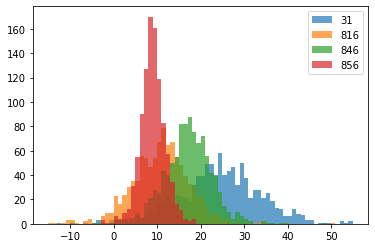

In [32]:
### run train on all data
trainset, testset, train_ds, test_ds, scaler = _data['all']

pm, mid = train_model(500,dropout = 0.1,id='all')
t[mid],s[mid], e[mid] = eval_model(pm, test_ds)
p[mid] = pm

mae = raw_eval(t[mid],s[mid])

run_test(t[mid], s[mid], [31,816,846,856])
pitmodel = save_full_pitmodel(mid, 'all', maxgap=65)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 151.64it/s, avg_epoch_loss=1.47]
INFO:root:Epoch[0] Elapsed time 0.661 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.469403
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 157.18it/s, avg_epoch_loss=1.14]
INFO:root:Epoch[1] Elapsed time 0.638 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1.137794
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 154.69it/s, avg_epoch_loss=0.915]
INFO:root:Epoch[2] Elapsed time 0.648 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.914556
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 169.43it/s, avg_epoch_loss=0.871]
INFO:root:Epoch[3] Elapsed time 0.592 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.870562
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 172.33it/s

100%|██████████| 100/100 [00:00<00:00, 174.33it/s, avg_epoch_loss=0.69]
INFO:root:Epoch[36] Elapsed time 0.575 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=0.690088
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 165.49it/s, avg_epoch_loss=0.712]
INFO:root:Epoch[37] Elapsed time 0.606 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.711858
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 170.42it/s, avg_epoch_loss=0.732]
INFO:root:Epoch[38] Elapsed time 0.588 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.732464
INFO:root:Loading parameters from best epoch (28)
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 171.69it/s, avg_epoch_loss=0.721]
INFO:root:Epoch[39] Elapsed time 0.585 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.720780
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 176.16it/s, avg_ep

INFO:root:Epoch[72] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 175.61it/s, avg_epoch_loss=0.718]
INFO:root:Epoch[72] Elapsed time 0.571 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.718308
INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 177.85it/s, avg_epoch_loss=0.681]
INFO:root:Epoch[73] Elapsed time 0.564 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.681050
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 179.53it/s, avg_epoch_loss=0.733]
INFO:root:Epoch[74] Elapsed time 0.558 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.732549
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 174.43it/s, avg_epoch_loss=0.738]
INFO:root:Epoch[75] Elapsed time 0.575 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.738408
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 178.53it/s,

100%|██████████| 100/100 [00:00<00:00, 181.94it/s, avg_epoch_loss=0.74]
INFO:root:Epoch[108] Elapsed time 0.551 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=0.740352
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.20it/s, avg_epoch_loss=0.705]
INFO:root:Epoch[109] Elapsed time 0.559 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.704802
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.39it/s, avg_epoch_loss=0.687]
INFO:root:Epoch[110] Elapsed time 0.553 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.686689
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.09it/s, avg_epoch_loss=0.712]
INFO:root:Epoch[111] Elapsed time 0.570 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.712036
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.99it/s, avg_epoch_loss=0.724]
INFO:root:Epoch[112] Ela

100%|██████████| 100/100 [00:00<00:00, 182.15it/s, avg_epoch_loss=0.712]
INFO:root:Epoch[144] Elapsed time 0.550 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=0.712461
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.87it/s, avg_epoch_loss=0.748]
INFO:root:Epoch[145] Elapsed time 0.545 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.748055
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.76it/s, avg_epoch_loss=0.717]
INFO:root:Epoch[146] Elapsed time 0.545 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.717432
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.92it/s, avg_epoch_loss=0.688]
INFO:root:Epoch[147] Elapsed time 0.545 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.688094
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.19it/s, avg_epoch_loss=0.719]
INFO:root:Epoch[148] El

100%|██████████| 100/100 [00:00<00:00, 179.78it/s, avg_epoch_loss=0.728]
INFO:root:Epoch[180] Elapsed time 0.558 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=0.727965
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.58it/s, avg_epoch_loss=0.731]
INFO:root:Epoch[181] Elapsed time 0.544 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.730786
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.39it/s, avg_epoch_loss=0.735]
INFO:root:Epoch[182] Elapsed time 0.547 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.735243
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.64it/s, avg_epoch_loss=0.718]
INFO:root:Epoch[183] Elapsed time 0.610 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.718372
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.66it/s, avg_epoch_loss=0.692]
INFO:root:Epoch[184] El

100%|██████████| 100/100 [00:00<00:00, 181.90it/s, avg_epoch_loss=0.704]
INFO:root:Epoch[216] Elapsed time 0.552 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=0.703948
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.98it/s, avg_epoch_loss=0.701]
INFO:root:Epoch[217] Elapsed time 0.558 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.701064
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.09it/s, avg_epoch_loss=0.707]
INFO:root:Epoch[218] Elapsed time 0.554 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.706632
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.04it/s, avg_epoch_loss=0.747]
INFO:root:Epoch[219] Elapsed time 0.557 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.746950
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.94it/s, avg_epoch_loss=0.719]
INFO:root:Epoch[220] El

100%|██████████| 100/100 [00:00<00:00, 179.66it/s, avg_epoch_loss=0.702]
INFO:root:Epoch[252] Elapsed time 0.558 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=0.702363
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.64it/s, avg_epoch_loss=0.705]
INFO:root:Epoch[253] Elapsed time 0.540 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.705442
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 182.54it/s, avg_epoch_loss=0.706]
INFO:root:Epoch[254] Elapsed time 0.549 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.705993
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.40it/s, avg_epoch_loss=0.718]
INFO:root:Epoch[255] Elapsed time 0.614 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.717514
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.91it/s, avg_epoch_loss=0.738]
INFO:root:Epoch[256] El

100%|██████████| 100/100 [00:00<00:00, 172.51it/s, avg_epoch_loss=0.685]
INFO:root:Epoch[288] Elapsed time 0.581 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=0.684649
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.21it/s, avg_epoch_loss=0.724]
INFO:root:Epoch[289] Elapsed time 0.553 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.723575
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.26it/s, avg_epoch_loss=0.705]
INFO:root:Epoch[290] Elapsed time 0.559 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.704936
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.17it/s, avg_epoch_loss=0.728]
INFO:root:Epoch[291] Elapsed time 0.547 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.727708
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.09it/s, avg_epoch_loss=0.693]
INFO:root:Epoch[292] El

100%|██████████| 100/100 [00:00<00:00, 161.74it/s, avg_epoch_loss=0.68]
INFO:root:Epoch[324] Elapsed time 0.620 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=0.679599
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.95it/s, avg_epoch_loss=0.693]
INFO:root:Epoch[325] Elapsed time 0.583 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.692864
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.70it/s, avg_epoch_loss=0.701]
INFO:root:Epoch[326] Elapsed time 0.580 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.701017
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.78it/s, avg_epoch_loss=0.712]
INFO:root:Epoch[327] Elapsed time 0.542 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.711806
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.88it/s, avg_epoch_loss=0.705]
INFO:root:Epoch[328] Ela

100%|██████████| 100/100 [00:00<00:00, 180.21it/s, avg_epoch_loss=0.73]
INFO:root:Epoch[360] Elapsed time 0.556 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=0.729559
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.66it/s, avg_epoch_loss=0.67]
INFO:root:Epoch[361] Elapsed time 0.552 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.670033
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.30it/s, avg_epoch_loss=0.677]
INFO:root:Epoch[362] Elapsed time 0.541 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.676574
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.31it/s, avg_epoch_loss=0.7]
INFO:root:Epoch[363] Elapsed time 0.535 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.699686
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.92it/s, avg_epoch_loss=0.699]
INFO:root:Epoch[364] Elapse

100%|██████████| 100/100 [00:00<00:00, 179.21it/s, avg_epoch_loss=0.72]
INFO:root:Epoch[396] Elapsed time 0.559 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=0.719797
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.72it/s, avg_epoch_loss=0.718]
INFO:root:Epoch[397] Elapsed time 0.587 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.717534
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 151.13it/s, avg_epoch_loss=0.688]
INFO:root:Epoch[398] Elapsed time 0.663 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.688146
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.50it/s, avg_epoch_loss=0.682]
INFO:root:Epoch[399] Elapsed time 0.578 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.681879
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.05it/s, avg_epoch_loss=0.716]
INFO:root:Epoch[400] Ela

100%|██████████| 100/100 [00:00<00:00, 180.46it/s, avg_epoch_loss=0.69]
INFO:root:Epoch[432] Elapsed time 0.555 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=0.690044
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.73it/s, avg_epoch_loss=0.721]
INFO:root:Epoch[433] Elapsed time 0.608 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.720548
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.27it/s, avg_epoch_loss=0.727]
INFO:root:Epoch[434] Elapsed time 0.544 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.727174
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.07it/s, avg_epoch_loss=0.684]
INFO:root:Epoch[435] Elapsed time 0.542 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.683758
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.82it/s, avg_epoch_loss=0.675]
INFO:root:Epoch[436] Ela

100%|██████████| 100/100 [00:00<00:00, 193.94it/s, avg_epoch_loss=0.719]
INFO:root:Epoch[468] Elapsed time 0.517 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=0.719060
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.86it/s, avg_epoch_loss=0.692]
INFO:root:Epoch[469] Elapsed time 0.523 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.692263
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 192.75it/s, avg_epoch_loss=0.707]
INFO:root:Epoch[470] Elapsed time 0.520 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.707448
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.76it/s, avg_epoch_loss=0.732]
INFO:root:Epoch[471] Elapsed time 0.523 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.731722
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.99it/s, avg_epoch_loss=0.679]
INFO:root:Epoch[472] El

{
    "MSE": 0.922615022583552,
    "abs_error": 3605.5270269594307,
    "abs_target_sum": 4883.632899466723,
    "abs_target_mean": 1.0253270836587702,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.0353874601944504,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1409.861401869293,
    "Coverage[0.1]": 0.13667856393029604,
    "QuantileLoss[0.5]": 3605.5270269594307,
    "Coverage[0.5]": 0.262019735460844,
    "QuantileLoss[0.9]": 1969.5693903192528,
    "Coverage[0.9]": 0.5903842116313248,
    "RMSE": 0.9605285121138009,
    "NRMSE": 0.9368020482656689,
    "ND": 0.7382878896063508,
    "wQuantileLoss[0.1]": 0.2886911098545604,
    "wQuantileLoss[0.5]": 0.7382878896063508,
    "wQuantileLoss[0.9]": 0.4033000495459688,
    "mean_wQuantileLoss": 0.4767596830022934,
    "MAE_Coverage": 0.19475820561270907
}
mae =  6.912240184757506
idx: 31 t: 18 p: 25
idx: 816 t: 2 p: 2
idx: 846 t: 35 p: 15
idx: 856 t: 25 p: 6
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:44<00:00, 213.33it/s]


{
    "MSE": 2.072099756308953,
    "abs_error": 58884.045941364646,
    "abs_target_sum": 80870.58516372032,
    "abs_target_mean": 1.6881449778461604,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5440069127184829,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 18850.915041648448,
    "Coverage[0.1]": 0.05383571652228369,
    "QuantileLoss[0.5]": 58884.045941364646,
    "Coverage[0.5]": 0.18883206345892914,
    "QuantileLoss[0.9]": 53647.7137817443,
    "Coverage[0.9]": 0.3778519987475211,
    "RMSE": 1.4394789877969574,
    "NRMSE": 0.8526986761726671,
    "ND": 0.7281268686526193,
    "wQuantileLoss[0.1]": 0.2330997729704228,
    "wQuantileLoss[0.5]": 0.7281268686526193,
    "wQuantileLoss[0.9]": 0.6633773413798844,
    "mean_wQuantileLoss": 0.5415346610009756,
    "MAE_Coverage": 0.2931600737570887
}
save model pitmodel-m65-mlp-dnoshort-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 47905 keys.


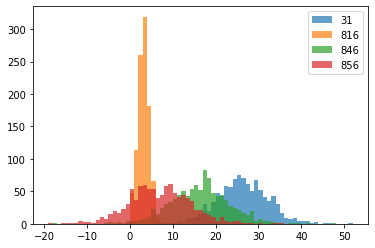

In [40]:
### run train on all data
tid = 'noshort'
trainset, testset, train_ds, test_ds, scaler = _data[tid]

pm, mid = train_model(500,dropout = 0.1,id=tid)
t[mid],s[mid], e[mid] = eval_model(pm, test_ds)
p[mid] = pm

mae = raw_eval(t[mid],s[mid])

run_test(t[mid], s[mid], [31,816,846,856])
pitmodel = save_full_pitmodel(mid, tid, maxgap=65)

In [ ]:
sys.exit(0)

### test and tuning

In [ ]:
s.keys()

In [ ]:
pm, mid = train_model(500,dropout = 0.1)
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pm, mid = train_model(2000,dropout = 0.1)
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
save_model(p[mid], mid)
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
mid

In [ ]:
t.keys()

In [ ]:
pm, mid = train_model(200,dropout = 0.1, layers=[8,4])
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
e={}

In [ ]:
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pm, mid = train_model(500, layers=[10,5])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

In [ ]:
pm, mid = train_model(500, layers=[32,16,8,4])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

In [ ]:
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pm, mid = train_model(2000, layers=[32,16,8,4])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

### test

In [ ]:
trec = next(iter(train_ds))
trec


In [ ]:
run_test(tss, forecasts, [31,816,846,856])

In [ ]:
test_sel.iloc[816]

In [ ]:
test_sel.iloc[836]

In [ ]:
t[mid],s[mid] = eval_model(pm)

In [ ]:
get_pred(t[mid],s[mid], 816)

In [ ]:
next(iter(test_ds))

In [ ]:
scaler

In [ ]:
pm, mid = train_model(2,dropout = 0.1)
#t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
#run_test(t[mid], s[mid], [31,816,846,856])

#mid = 'mlp-e2000-l10-10-5-student-d0.1'
save_model(p[mid], mid)

### test pitmodel

In [ ]:
_scaler = scaler

In [ ]:
id = 'mlp-e2000-l10-10-5-student-d0.1'
t[id],s[id], e[id] = eval_model(p[id])

In [ ]:
forecasts = s[id]
tss = t[id]

scaler = _scaler
testset = test_sel[['lap2nextpit','caution_laps','pitage']].values

pitmodel = PitModel()

pitmodel.save_model('pitmodel_test', testset, forecasts, scaler)

In [ ]:
newcasts = pitmodel.forecast_ds(testset, forecasts)
scaler = _scaler
run_test(tss, newcasts, [31,816,846,856],raw_forecast=True)

In [ ]:
plt.plot(pitmodel.model['0-0'][0,:], pitmodel.model['0-0'][1,:])

In [ ]:
plt.plot(pitmodel.model['10-13'][0,:], pitmodel.model['10-13'][1,:])

In [ ]:
pitmodel.model['0-0'][0,:]

In [ ]:
scaler = _scaler
test_all = df_test[['lap2nextpit','caution_laps','pitage']].values
test_ds, _, test_set = makedb(test_all, scaler, perm=False)

id = 'mlp-e2000-l10-10-5-student-d0.1'
t[id],s[id], e[id] = eval_model(p[id])
forecasts = s[id]
tss = t[id]

pitmodel = PitModel()

pitmodel.save_model(f'mlp-{id}.pickle', test_all, forecasts, scaler)


In [ ]:
len(forecasts)

In [ ]:
testall_set

In [ ]:
scaler = _scaler
maxgap = 60
test_ds, _, test_set, test_all = make_fulltestdb(scaler, maxgap = maxgap)

id = 'mlp-e2000-l10-10-5-student-d0.1'

t[id],s[id], e[id] = eval_model(p[id])
forecasts = s[id]
tss = t[id]

pitmodel = PitModel()

pitmodel.save_model(f'pitmodel-m{maxgap}-{id}.pickle', test_all, forecasts, scaler)

In [ ]:
pitmodel.model['0-0'][0,:]

In [ ]:
plt.plot(pitmodel.model['0-0'][0,:], pitmodel.model['0-0'][1,:])

In [ ]:
t.keys()

In [ ]:
t['mlp-dsel-e500-l10-10-5-student-d0.1'][0]

### shortterm predictions using pitmodel(plen=2)

convert forecast samples of pitmodel to forecast samples of pit@plen laps

In [18]:
test_car12 = df_test[df_test['carno']==12]

In [19]:
test_ds, _, test_set = makedb(test_car12[['lap2nextpit','caution_laps','pitage']].values, scaler, perm=False)

In [20]:
len(test_set)

170

In [21]:
test

array([[ 1.88149958, -0.70945244, -1.40995345],
       [ 1.76852039, -0.70945244, -1.29736294],
       [ 1.6555412 , -0.70945244, -1.18477243],
       [ 1.54256201, -0.70945244, -1.07218192],
       [ 1.42958282, -0.70945244, -0.95959142],
       [ 1.31660363, -0.70945244, -0.84700091],
       [ 1.20362444, -0.70945244, -0.7344104 ],
       [ 1.09064525, -0.70945244, -0.62181989],
       [ 0.97766607, -0.70945244, -0.50922938],
       [ 0.86468688, -0.70945244, -0.39663887],
       [ 0.75170769, -0.70945244, -0.28404836],
       [ 0.6387285 , -0.70945244, -0.17145786],
       [ 0.52574931, -0.70945244, -0.05886735],
       [ 0.41277012, -0.70945244,  0.05372316],
       [ 0.29979093, -0.70945244,  0.16631367],
       [ 0.18681174, -0.70945244,  0.27890418],
       [ 0.07383255, -0.70945244,  0.39149469],
       [-0.03914664, -0.70945244,  0.5040852 ],
       [-0.15212582, -0.70945244,  0.6166757 ],
       [-0.26510501, -0.70945244,  0.72926621],
       [-0.3780842 , -0.70945244,  0.841

In [23]:
test_car12[test_car12['lap']==31]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len
1059,18.0,0.0,0.0,1.0,12,5,31,18.0


In [24]:
test_car12[test_car12['lap']==30]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len
1058,1.0,0.0,31.0,0.0,12,5,30,31.0


In [25]:
test_ds

[{'target': array([1.88149958]),
  'feat': array([-0.70945244, -1.40995345]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([1.76852039]),
  'feat': array([-0.70945244, -1.29736294]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([1.6555412]),
  'feat': array([-0.70945244, -1.18477243]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([1.54256201]),
  'feat': array([-0.70945244, -1.07218192]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([1.42958282]),
  'feat': array([-0.70945244, -0.95959142]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target':

In [26]:
len(test_ds)

170

In [28]:
test_set

array([[ 1.88149958, -0.70945244, -1.40995345],
       [ 1.76852039, -0.70945244, -1.29736294],
       [ 1.6555412 , -0.70945244, -1.18477243],
       [ 1.54256201, -0.70945244, -1.07218192],
       [ 1.42958282, -0.70945244, -0.95959142],
       [ 1.31660363, -0.70945244, -0.84700091],
       [ 1.20362444, -0.70945244, -0.7344104 ],
       [ 1.09064525, -0.70945244, -0.62181989],
       [ 0.97766607, -0.70945244, -0.50922938],
       [ 0.86468688, -0.70945244, -0.39663887],
       [ 0.75170769, -0.70945244, -0.28404836],
       [ 0.6387285 , -0.70945244, -0.17145786],
       [ 0.52574931, -0.70945244, -0.05886735],
       [ 0.41277012, -0.70945244,  0.05372316],
       [ 0.29979093, -0.70945244,  0.16631367],
       [ 0.18681174, -0.70945244,  0.27890418],
       [ 0.07383255, -0.70945244,  0.39149469],
       [-0.03914664, -0.70945244,  0.5040852 ],
       [-0.15212582, -0.70945244,  0.6166757 ],
       [-0.26510501, -0.70945244,  0.72926621],
       [-0.3780842 , -0.70945244,  0.841

### test

In [19]:
df12 = df_test[(df_test['eid']==5) & (df_test['carno']==12)]

In [20]:
df12[(df12['lap']>=45) & (df12['lap']<55)]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
1073,4.0,0.0,14.0,1.0,12,5,45,18.0,0.0
1074,3.0,0.0,15.0,1.0,12,5,46,18.0,0.0
1075,2.0,1.0,16.0,1.0,12,5,47,18.0,1.0
1076,1.0,2.0,17.0,1.0,12,5,48,18.0,2.0
1077,44.0,0.0,0.0,0.0,12,5,49,44.0,0.0
1078,43.0,1.0,1.0,0.0,12,5,50,44.0,1.0
1079,42.0,2.0,2.0,0.0,12,5,51,44.0,2.0
1080,41.0,3.0,3.0,0.0,12,5,52,44.0,3.0
1081,40.0,4.0,4.0,0.0,12,5,53,44.0,4.0
1082,39.0,4.0,5.0,0.0,12,5,54,44.0,0.0


In [21]:
df12

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
1028,31.0,0.0,1.0,0.0,12,5,0,31.0,0.0
1029,30.0,0.0,2.0,0.0,12,5,1,31.0,0.0
1030,29.0,0.0,3.0,0.0,12,5,2,31.0,0.0
1031,28.0,0.0,4.0,0.0,12,5,3,31.0,0.0
1032,27.0,0.0,5.0,0.0,12,5,4,31.0,0.0
...,...,...,...,...,...,...,...,...,...
1193,5.0,20.0,37.0,0.0,12,5,165,42.0,0.0
1194,4.0,20.0,38.0,0.0,12,5,166,42.0,0.0
1195,3.0,20.0,39.0,0.0,12,5,167,42.0,0.0
1196,2.0,20.0,40.0,0.0,12,5,168,42.0,0.0


In [22]:
df12.cur_cautionlaps.values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1.,
       2., 3., 4., 0., 0., 0., 1., 2., 3., 4., 5., 0., 0., 0., 0., 0., 1.,
       2., 3., 4., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 2., 3., 4., 5., 6., 0., 1., 2., 3., 4., 5., 6., 7., 0.,
       1., 2., 3., 4., 5., 6., 7., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
train_set

array([[ 1.56895685, -0.64173227, -1.57348481, -0.21381922],
       [ 1.24715782, -0.64173227, -1.68074602, -0.21381922],
       [ 0.60355976, -0.64173227, -0.60813392, -0.21381922],
       ...,
       [ 0.06722804,  1.35544334,  0.35721696, -0.21381922],
       [-0.89816905,  0.35685554,  0.67900059, -0.21381922],
       [-0.68363636,  3.01975635,  1.53709027, -0.21381922]])

In [33]:
samples = np.zeros((1000))
for i in range(1000):
    samples[i] = pitmodel.predict(1,16,1)
    
samples[samples<5]

array([4., 4., 2., 2., 4., 4., 4., 3., 4., 1., 2., 4., 2., 3., 3., 2., 2.,
       3., 4., 4., 1., 3., 2., 2., 3., 4., 2., 4., 3., 4., 4., 1., 4., 3.,
       1., 4., 1., 1., 2., 1., 3., 1., 4., 2., 4., 3., 4., 2., 3., 4., 4.,
       2., 2., 1., 4., 2., 3., 3., 2., 2., 2., 4., 4., 4., 4., 1., 1., 3.,
       2., 2., 4., 4., 2., 1., 2., 1., 2., 3., 1., 3., 2., 2., 4., 2., 2.,
       1., 2., 4., 4., 2., 1., 4., 4., 2., 2., 1., 4., 4., 2., 3., 4., 4.,
       3., 3., 1., 3., 4., 4., 2., 2., 3., 4., 4., 3., 4.])

In [34]:
np.sum(samples<5)

115

In [35]:
np.min(samples)

1.0

In [36]:
np.max(samples)

39.0